In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'savefig.dpi': 1200})
tab20_colors = plt.cm.get_cmap('tab20').colors
tab20_colors = [c for i, c in enumerate(tab20_colors) if i//2 not in [4, 5, 6]]

import os, random, time, pickle, torch
import numpy as np

from jarvis.utils import time_str

if not os.path.exists('figs'):
    os.makedirs('figs')

In [2]:
def radial_mean(f, bin_num=25, exclude_cardinal=False):
    resol = 32
    dx, dy = np.meshgrid(np.arange(resol)/resol, np.arange(resol)/resol)
    dx = np.mod(fftshift(dx)+0.5, 1)-0.5
    dy = np.mod(fftshift(dy)+0.5, 1)-0.5
    mask_cardinal = np.logical_or(dx==0, dy==0)

    k = (dx**2+dy**2)**0.5
    k_edges = np.linspace(0, 0.5, bin_num+1)
    k_centers = 0.5*(k_edges[:-1]+k_edges[1:])

    f_means = []
    for i in range(bin_num):
        mask = np.logical_and(k>=k_edges[i], k<k_edges[i+1])
        if exclude_cardinal:
            mask = np.logical_and(mask, np.logical_not(mask_cardinal))
        if np.any(mask):
            f_means.append(f[mask].mean())
        else:
            f_means.append(np.nan)
    f_means = np.array(f_means)
    return k_centers, f_means

In [3]:
from jarvis.vision import prepare_datasets
from torch.utils.data import DataLoader

dataset = prepare_datasets('CIFAR10', 'vision_datasets')
loader = DataLoader(dataset)
images = torch.cat([img for img, _ in loader]).numpy()

# Specify models for testing

In [4]:
with open('sim-reg/model.ids.pickle', 'rb') as f:
    catalog = pickle.load(f)
export_dirs = {}
for key in ['none', 'neural', 'shuffle']:
    export_dirs[key] = 'sim-reg/exported'

with open('blur-net/model.ids.pickle', 'rb') as f:
    catalog['blur'] = pickle.load(f)
export_dirs['blur'] = 'blur-net/exported'

with open('augmix/model.ids.pickle', 'rb') as f:
    catalog['augmix'] = pickle.load(f)
export_dirs['augmix'] = 'augmix/exported'

for key in catalog:
    catalog[key] = catalog[key][:5]

catalog_keys = ['none', 'neural', 'shuffle', 'blur', 'augmix']

In [5]:
print('accuracy on clean dataset')
clean_accs = {}
for key, model_ids in catalog.items():
    clean_accs[key] = []
    for model_id in model_ids:
        saved = torch.load(f'{export_dirs[key]}/{model_id}.pt')
        clean_accs[key].append(saved['accs']['test'][saved['best_epoch']])
    if clean_accs[key]:
        print('{:10} {:.2%} ({:.2%})'.format('\'{}\':'.format(key), np.mean(clean_accs[key]), np.std(clean_accs[key])/len(clean_accs[key])**0.5))

accuracy on clean dataset
'none':    92.36% (0.16%)
'neural':  88.35% (0.29%)
'shuffle': 88.78% (0.70%)
'blur':    88.14% (0.55%)
'augmix':  88.38% (0.09%)


# Test model robustness against common corruptions

In [6]:
from roarena.corruption_tester import CorruptionTestJob

job = CorruptionTestJob('save/corruption_tests', 'vision_datasets')
corruptions = [
    'gaussian_noise', 'shot_noise', 'impulse_noise',
    'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur',
    'snow', 'frost', 'fog', 'brightness',
    'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression',
]

# test models with common corruptions
corrupt_accs = {}
accs_mean = np.full((len(catalog), len(corruptions)+1), np.nan)
accs_sem = np.full((len(catalog), len(corruptions)+1), np.nan)
for k_idx, key in enumerate(catalog_keys):
    model_ids = catalog[key]
    print('testing {} \'{}\' models...'.format(len(model_ids), key))
    corrupt_accs[key] = {}
    for corruption in corruptions:
        corrupt_accs[key][corruption] = []
    
    tic = time.time()
    for model_id in model_ids:
        model_pth = f'{export_dirs[key]}/{model_id}.pt'
        for corruption in corruptions:
            _accs = []
            for severity in range(1, 6):
                config = job.get_work_config(f'--model_pth {model_pth} --corruption {corruption} --severity {severity}'.split())
                w_id = job.process(config, policy='preserve', silent_mode=True)
                output = job.outputs.fetch_record(w_id)
                _accs.append(output['acc'])
            corrupt_accs[key][corruption].append(np.mean(_accs))
    
    accs_mean[k_idx, 0] = np.mean(clean_accs[key])
    accs_sem[k_idx, 0] = np.std(clean_accs[key])/len(clean_accs[key])**0.5
    for c_idx, corruption in enumerate(corruptions, 1):
        accs_mean[k_idx, c_idx] = np.mean(corrupt_accs[key][corruption])
        accs_sem[k_idx, c_idx] = np.std(corrupt_accs[key][corruption])/len(model_ids)**0.5
    
    toc = time.time()
    print(time_str(toc-tic))

testing 5 'none' models...
1m34.81s
testing 5 'neural' models...
1m26.02s
testing 4 'shuffle' models...
0m48.37s
testing 5 'blur' models...
0m55.04s
testing 5 'augmix' models...
0m58.41s


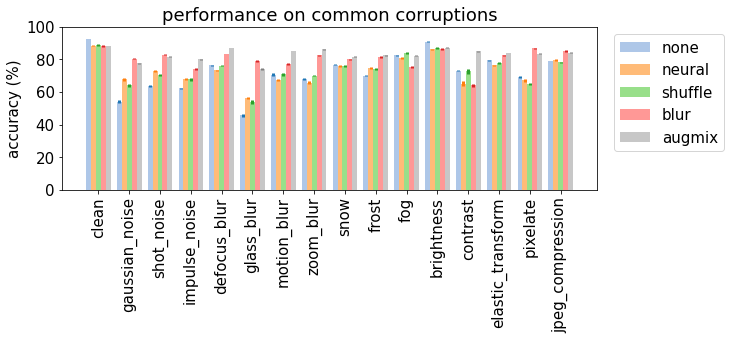

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={'wspace': 0, 'width_ratios': [4, 1]})

ax = axes[0]
width = 0.8/len(catalog)
h_bars = []
for k_idx, key in enumerate(catalog_keys):
    if catalog[key]:
        ecolor = tab20_colors[k_idx*2]
        fcolor = tab20_colors[k_idx*2+1]
        x = np.arange(len(corruptions)+1)+(k_idx-(len(catalog)-1)/2)*width
        h_bars.append(ax.bar(x, accs_mean[k_idx]*100, width, yerr=accs_sem[k_idx]*100, facecolor=fcolor, ecolor=ecolor))
ax.set_xticks(np.arange(len(corruptions)+1))
ax.set_xticklabels(['clean']+corruptions, rotation=90)
ax.set_ylabel('accuracy (%)')
ax.set_ylim([0, 100])
ax.set_title('performance on common corruptions')
axes[1].legend(h_bars, catalog_keys)
axes[1].axis('off')
plt.show()
fig.savefig('figs/cifar10-c.svg')

# Test model robustness against adversarial robustness

In [8]:
from roarena.adversarial_attacker import AdvAttackJob

job = AdvAttackJob('save/adversarial_attacks', 'vision_datasets')

/foolbox/foolbox/attacks/brendel_bethge.py:624: UserWarning: At the first initialisation the optimizer needs to be compiled. This may take between 20 to 60 seconds.
  warnings.warn(


In [9]:
from jarvis.utils import match_cond

def best_attack(job, model_pth, metric='L2', use_BB=False):
    if use_BB:
        names = ['PGD', 'BI', 'DF', 'BB']
    else:
        names = ['PGD', 'BI', 'DF']
    
    w_ids, count = [], 0
    for name in names:
        cond = {
            'model_pth': model_pth,
            'attack_config': {
                'metric': metric,
                'name': name,
                'success_threshold': 0.999,
            }
        }        
        _w_ids = job.configs.fetch_matched(lambda r: match_cond(r, cond))
        has_completed = False
        for w_id in _w_ids:
            if job.is_completed(w_id):
                w_ids.append(w_id)
                has_completed = True
        if has_completed:
            count += 1

    if count<len(names):
        return None, None, None

    advs, successes, dists = [], [], []
    for w_id in w_ids:
        output = job.outputs.fetch_record(w_id)
        advs.append(output['advs'])
        successes.append(output['successes'])
        dists.append(output['dists'])
    
    min_idxs = np.argmin(dists, axis=0)
    advs = np.array([advs[min_idx][i] for i, min_idx in enumerate(min_idxs)])
    successes = np.array([successes[min_idx][i] for i, min_idx in enumerate(min_idxs)])
    dists = np.array([dists[min_idx][i] for i, min_idx in enumerate(min_idxs)])
    return advs, successes, dists


metric: Linf, use_BB: False
testing 5 'none' models...
5 models with all attacks performed
0m29.76s
testing 5 'neural' models...
5 models with all attacks performed
0m25.82s
testing 4 'shuffle' models...
4 models with all attacks performed
0m21.05s
testing 5 'blur' models...
5 models with all attacks performed
0m26.38s
testing 5 'augmix' models...
5 models with all attacks performed
0m25.13s

metric: L2, use_BB: False
testing 5 'none' models...
4 models with all attacks performed
0m35.69s
testing 5 'neural' models...
3 models with all attacks performed
0m25.29s
testing 4 'shuffle' models...
4 models with all attacks performed
0m31.32s
testing 5 'blur' models...
5 models with all attacks performed
0m31.59s
testing 5 'augmix' models...
3 models with all attacks performed
0m20.64s


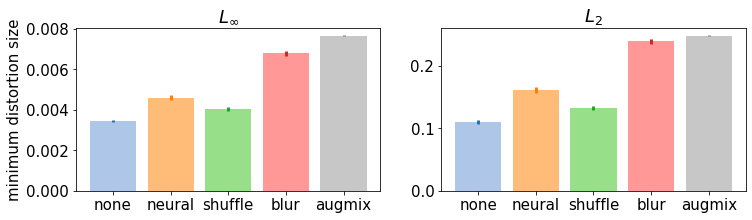

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

use_BB = False
advs, successes, dists = {}, {}, {}
for ax, metric in zip(axes, ['Linf', 'L2']):
    print(f'\nmetric: {metric}, use_BB: {use_BB}')
    advs[metric], successes[metric], dists[metric] = {}, {}, {}
    dists_mean = np.full((len(catalog),), np.nan)
    dists_sem = np.full((len(catalog),), np.nan)
    for k_idx, key in enumerate(catalog_keys):
        model_ids = catalog[key]
        print('testing {} \'{}\' models...'.format(len(model_ids), key))
        advs[metric][key], successes[metric][key], dists[metric][key] = [], [], []

        tic = time.time()
        for model_id in model_ids:
            model_pth = f'{export_dirs[key]}/{model_id}.pt'
            _advs, _successes, _dists = best_attack(job, model_pth, metric, use_BB)
            if _advs is not None:
                advs[metric][key].append(_advs)
                successes[metric][key].append(_successes)
                dists[metric][key].append(_dists)
        print(f'{len(dists[metric][key])} models with all attacks performed')

        dists_mean[k_idx] = np.mean(dists[metric][key])
        dists_sem[k_idx] = np.std(np.mean(dists[metric][key], axis=1))/len(dists[metric][key])**0.5

        toc = time.time()
        print(time_str(toc-tic))
        
    for k_idx, key in enumerate(catalog_keys):
        if catalog[key]:
            ecolor = tab20_colors[k_idx*2]
            fcolor = tab20_colors[k_idx*2+1]
            ax.bar(k_idx, dists_mean[k_idx], 0.8, yerr=dists_sem[k_idx], facecolor=fcolor, ecolor=ecolor)
    ax.set_xticks(np.arange(len(catalog_keys)))
    ax.set_xticklabels(catalog_keys)
    if metric=='L2':
        ax.set_title(r'$L_2$')
    if metric=='Linf':
        ax.set_title(r'$L_\infty$')
axes[0].set_ylabel('minimum distortion size')
plt.show()
fig.savefig('figs/adv_robustness.svg')

# Fourier analysis on adversarial attacks

In [11]:
from scipy.fft import fft2, fftshift

metric = 'L2'
f = {}
for key in catalog_keys:
    f[key] = np.power(np.abs(fftshift(fft2(np.stack(advs[metric][key])-images))), 2).mean(axis=(0, 1, 2))

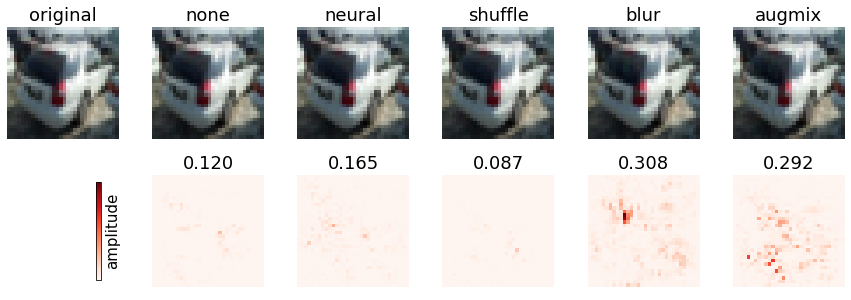

In [12]:
i_idx = random.choice(range(10000))
i_idx = 7734
examples, diffs = {}, {}
for key in catalog_keys:
    examples[key] = advs[metric][key][0][i_idx]
    diffs[key] = np.power(np.abs(examples[key]-images[i_idx]), 2).sum(axis=0)
vmax = max([v.max() for v in diffs.values()])
    
fig, axes = plt.subplots(2, len(catalog)+1, figsize=(2.5*(len(catalog)+1), 5), gridspec_kw={'wspace': 0.3})
axes[0, 0].imshow(images[i_idx].transpose(1, 2, 0))
axes[0, 0].axis('off')
axes[0, 0].set_title('original')
axes[1, 0].axis('off')
for k_idx, key in enumerate(catalog_keys, 1):
    axes[0, k_idx].imshow(examples[key].transpose(1, 2, 0))
    axes[0, k_idx].axis('off')
    axes[0, k_idx].set_title(key)
    h = axes[1, k_idx].imshow(diffs[key], vmin=0, vmax=vmax, cmap='Reds')
    axes[1, k_idx].axis('off')
    axes[1, k_idx].set_title('{:.3f}'.format(dists[metric][key][0][i_idx]))
plt.colorbar(h, ax=axes[1, 0], fraction=0.2, shrink=0.8, label='amplitude', ticks=[])
plt.show()
fig.savefig('figs/adv_examples.svg')

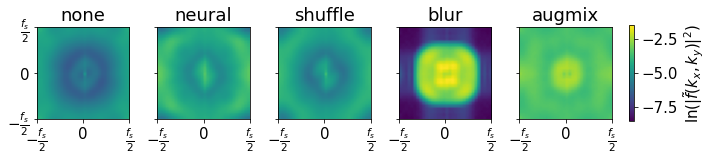

In [13]:
fig, axes = plt.subplots(1, len(catalog), figsize=(2.5*len(catalog), 2.5), gridspec_kw={'wspace': 0.3})
vmin = np.min([np.log(v.min()) for v in f.values()])
vmax = np.max([np.log(v.max()) for v in f.values()])
for key, ax in zip(catalog_keys, axes):
    h = ax.imshow(np.log(f[key]), extent=[-1, 1, -1, 1], vmin=vmin, vmax=vmax)
    ax.set_xticks([-1, 0, 1])
    ax.set_xticklabels([r'$-\frac{f_s}{2}$', '0', r'$\frac{f_s}{2}$'])
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels([])
    ax.set_title(key)
axes[0].set_yticklabels([r'$-\frac{f_s}{2}$', '0', r'$\frac{f_s}{2}$'])
plt.colorbar(h, ax=axes, shrink=0.7, pad=0.025, label=r'$\ln(|\tilde{f}(k_x, k_y)|^2)$')
plt.show()
fig.savefig('figs/adv_spectrum_planar.svg')

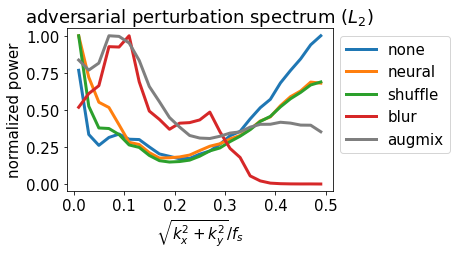

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw={'width_ratios': [3, 1]})
hs = []
for k_idx, key in enumerate(catalog_keys):
    k_edges, f_means = radial_mean(f[key])
    h, = axes[0].plot(k_edges, f_means/f_means.max(), color=tab20_colors[k_idx*2])
    hs.append(h)
axes[0].set_xlabel(r'$\sqrt{k_x^2+k_y^2}/f_s$')
axes[0].set_ylabel('normalized power')
axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
if metric=='Linf':
    metric_str = r'$L_\infty$'
if metric=='L2':
    metric_str = r'$L_2$'
axes[0].set_title(f'adversarial perturbation spectrum ({metric_str})')
axes[1].legend(hs, catalog_keys)
axes[1].axis('off')
plt.show()
fig.savefig('figs/adv_spectrum_radial.svg')

# Einstein-Monroe experiments

In [15]:
from roarena.einmon_tester import EinMonJob

job = EinMonJob('save/einstein-monroe', 'vision_datasets')

alphas = np.arange(20)*0.05
accs_low, accs_high = {}, {}
for key, model_ids in catalog.items():
    accs_low[key] = []
    accs_high[key] = []
    
    for model_id in model_ids:
        model_pth = f'{export_dirs[key]}/{model_id}.pt'
        
        _accs_low, _accs_high = [], []
        for alpha in alphas:
            config = job.get_work_config(f'--model_pth {model_pth} --alpha {alpha}'.split())
            w_id = job.process(config, policy='preserve', silent_mode=True)
            output = job.outputs.fetch_record(w_id)
            _accs_low.append(output['acc_low'])
            _accs_high.append(output['acc_high'])
        accs_low[key].append(_accs_low)
        accs_high[key].append(_accs_high)

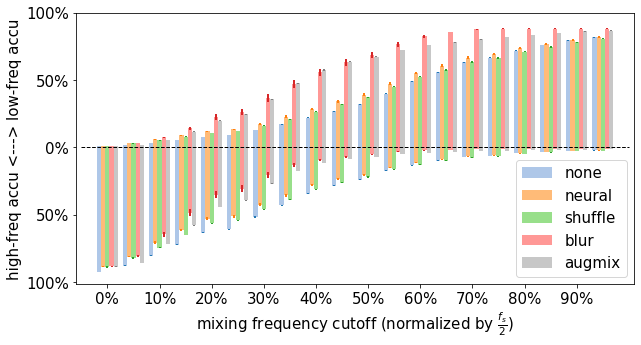

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

width = 0.8/len(catalog_keys)
h_bars = []
for k_idx, key in enumerate(catalog_keys):
    if catalog[key]:
        ecolor = tab20_colors[k_idx*2]
        fcolor = tab20_colors[k_idx*2+1]
        x = np.arange(len(alphas))+(k_idx-(len(catalog)-1)/2)*width
        h_bars.append(ax.bar(x, np.mean(accs_low[key], axis=0)*100, width,
                             yerr=np.std(accs_low[key], axis=0)/len(accs_low[key])**0.5*100,
                             error_kw={'elinewidth': 2},
                             facecolor=fcolor, ecolor=ecolor))
        ax.bar(x, -np.mean(accs_high[key], axis=0)*100, width,
               yerr=np.std(accs_high[key], axis=0)/len(accs_high[key])**0.5*100,
               error_kw={'elinewidth': 2},
               facecolor=fcolor, ecolor=ecolor)
ax.plot([-1, 20], [0, 0], 'k--', linewidth=1)
ax.set_xlim([-1.2, 20.2])
ax.set_xticks(np.arange(10)*2)
ax.set_xticklabels(['{:.0%}'.format(alpha) for alpha in np.arange(10)*0.1])
ax.set_yticks([-100, -50, 0, 50, 100])
ax.set_yticklabels(['100%', '50%', '0%', '50%', '100%'])
ax.legend(h_bars, catalog_keys, loc='lower right')
ax.set_xlabel(r'mixing frequency cutoff (normalized by $\frac{f_s}{2}$)')
ax.set_ylabel('high-freq accu <---> low-freq accu')
plt.show()
fig.savefig('figs/einmon_results.svg')

# Reconstruction Fourier analysis

In [17]:
from roarena.reconstructor import ReconsJob

job = ReconsJob('save/reconstructions', 'vision_datasets')

In [21]:
acts_orig_all[2].shape

(200, 16384)

In [24]:
output.keys()

dict_keys(['imgs_reco', 'acts_orig'])

In [25]:
output['imgs_reco'].shape

(1000, 3, 32, 32)

In [26]:
output['acts_orig'].shape

(1000, 65536)

In [27]:
acts_reco.shape

(1000, 65536)

In [29]:
acts_orig_all[1].shape

(200, 32768)

In [30]:
w_ids

['EF537364',
 '88515DA1',
 '4C618162',
 '40A4F13B',
 '9903FF79',
 '12ED0109',
 'DA8C66BB',
 '85112442',
 'C5A5A2FA',
 '05D32D79',
 '908B0BBA',
 '57B98D91',
 '7B8F8093',
 '81EE8825',
 '8124656A',
 '70B253C1',
 'B787461A',
 '7C6A3F03',
 '721A9596',
 'A7F7951A',
 '80FFF1E9',
 'E340D15C',
 '4F240067',
 '06545D56',
 '44C4DF95',
 '103D8BC6',
 'CE2C2BE2',
 'FF61488B',
 '4E5AE41E',
 '11C38825',
 '3E48EDC4',
 '8244ED0D',
 '4975FCF8',
 '65741C62',
 '54BE7E5C',
 'F6A3A10F',
 'CF77E68B',
 'CFCDD207',
 '2917D9EA']

In [36]:
job.configs.fetch_record(w_ids[5])

{'model_pth': 'sim-reg/exported/4EB279F4.pt',
 'recons_config': {'k_idx': 0,
  'l_idx': 9,
  'noise': 0.02,
  'sigma': 0.1,
  'lr': 0.001,
  'step_num': 1000,
  'alpha': 0.001}}

In [37]:
cond

{'model_pth': 'sim-reg/exported/4EB279F4.pt',
 'recons_config': {'l_idx': 0, 'noise': 0.02, 'alpha': 0.001}}

In [51]:
_w_ids = job.configs.fetch_matched(lambda r: match_cond(r, cond))
_config = job.configs.fetch_record(_w_ids[0])

In [52]:
_config

{'model_pth': 'sim-reg/exported/4EB279F4.pt',
 'recons_config': {'k_idx': 1,
  'l_idx': 12,
  'noise': 0.02,
  'sigma': 0.1,
  'lr': 0.001,
  'step_num': 1000,
  'alpha': 0.001}}

In [53]:
match_cond(_config, cond)

True

In [54]:
from jarvis.utils import flatten

flat_config = flatten(_config)
flat_cond = flatten(cond)

In [55]:
flat_config

{'model_pth': 'sim-reg/exported/4EB279F4.pt',
 'recons_config::k_idx': 1,
 'recons_config::l_idx': 12,
 'recons_config::noise': 0.02,
 'recons_config::sigma': 0.1,
 'recons_config::lr': 0.001,
 'recons_config::step_num': 1000,
 'recons_config::alpha': 0.001}

In [57]:
flat_cond

{'model_pth': 'sim-reg/exported/4EB279F4.pt',
 'recons_config::l_idx': 0,
 'recons_config::noise': 0.02,
 'recons_config::alpha': 0.001}

In [60]:
0 == {}

False

In [61]:
for key in flat_cond:
    if flat_cond[key]!={} and (key not in flat_config or flat_cond[key]!=flat_config[key]):
        print(False)

False


In [18]:
from torch.utils.data import TensorDataset, Subset, DataLoader
from jarvis.utils import match_cond
from jarvis.vision import prepare_datasets
from scipy.fft import fft2, fftshift

mses, f_reco, act_corr = {}, {}, {}
examples = {}
act_samples = {}

device = 'cuda'
l_idx, noise, alpha = 0, 0.02, 0.001

for key, model_ids in catalog.items():
    print('analyzing reconstruction of {} \'{}\' models...'.format(len(model_ids), key))
    mses[key], f_reco[key], act_corr[key] = [], [], []
    examples[key] = []
    act_samples[key] = []

    tic = time.time()
    for model_id in model_ids:
        model_pth = f'{export_dirs[key]}/{model_id}.pt'
        model = torch.load(model_pth)['model']
        model.eval().to(device)
        
        cond = {
            'model_pth': model_pth,
            'recons_config': {
                'l_idx': l_idx,
                'noise': noise,
                'alpha': alpha,
            }
        }
        w_ids = [w_id for w_id in job.configs.fetch_matched(lambda r: match_cond(r, cond)) if job.is_completed(w_id)]
        
        imgs_orig_all, imgs_reco_all = [], []
        acts_orig_all, acts_reco_all = [], []

        for w_id in w_ids:
            config = job.configs.fetch_record(w_id)
            output = job.outputs.fetch_record(w_id)

            k_idx = config['recons_config']['k_idx']
            dataset = prepare_datasets('CIFAR10', 'vision_datasets')
            dataset = Subset(dataset, list(range(
                k_idx*1000, (k_idx+1)*1000
                )))

            loader = DataLoader(dataset, batch_size=16)
            imgs_orig = []
            for _imgs, _ in loader:
                imgs_orig.append(_imgs)
            imgs_orig = torch.cat(imgs_orig).numpy()

            dataset = TensorDataset(torch.tensor(output['imgs_reco'], dtype=torch.float))
            loader = DataLoader(dataset, batch_size=16)

            acts_reco = []
            for _imgs, in loader:
                with torch.no_grad():
                    activations = model.layer_activations(_imgs.to(device))
                acts_reco.append(activations[l_idx].flatten(1).cpu())
            acts_reco = torch.cat(acts_reco).numpy()
            
            idxs = random.sample(range(len(imgs_orig)), 200)
            if config['recons_config']['k_idx']==0:
                examples[key].append(output['imgs_reco'])
                act_samples[key].append((output['acts_orig'][idxs], acts_reco[idxs]))            
            imgs_orig_all.append(imgs_orig[idxs])
            imgs_reco_all.append(output['imgs_reco'][idxs])
            acts_orig_all.append(output['acts_orig'][idxs])
            acts_reco_all.append(acts_reco[idxs])
        imgs_orig_all = np.concatenate(imgs_orig_all)
        imgs_reco_all = np.concatenate(imgs_reco_all)
        acts_orig_all = np.concatenate(acts_orig_all)
        acts_reco_all = np.concatenate(acts_reco_all)
        
        mses[key].append(np.power(imgs_reco_all-imgs_orig_all, 2).mean())
        f_reco[key].append(np.power(np.abs(fftshift(fft2(imgs_reco_all-imgs_orig_all))), 2).mean(axis=(0, 1)))
        act_corr[key].append(np.corrcoef(acts_orig_all.flatten(), acts_reco_all.flatten())[0, 1])
        
    toc = time.time()
    print(time_str(toc-tic))

analyzing reconstruction of 5 'none' models...


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 65536 and the array at index 1 has size 32768

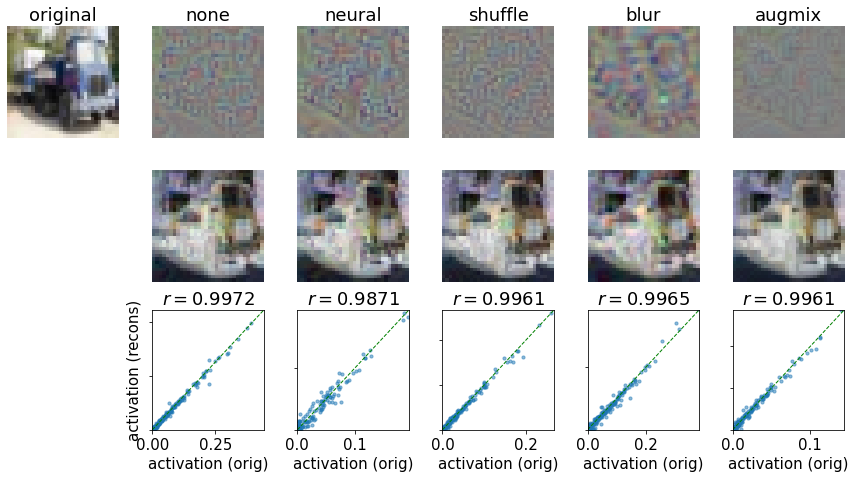

In [62]:
i_idx = random.choice(range(1000))
i_idx = 28
diffs = {}
for key in catalog_keys:
    diffs[key] = examples[key][0][i_idx]-images[i_idx]
vmin = min([v.min() for v in diffs.values()])
vmax = max([v.max() for v in diffs.values()])

fig, axes = plt.subplots(3, len(catalog)+1, figsize=(2.5*(len(catalog)+1), 7.5), gridspec_kw={'wspace': 0.3})
axes[0, 0].imshow(images[i_idx].transpose(1, 2, 0))
axes[0, 0].axis('off')
axes[0, 0].set_title('original')
axes[1, 0].axis('off')
axes[2, 0].axis('off')
for k_idx, key in enumerate(catalog_keys, 1):
    axes[0, k_idx].imshow(np.clip(examples[key][0][i_idx].transpose(1, 2, 0), 0, 1))
    axes[0, k_idx].axis('off')
    axes[0, k_idx].set_title(key)
    h = axes[1, k_idx].imshow(((diffs[key]-vmin)/(vmax-vmin)).transpose(1, 2, 0))
    axes[1, k_idx].axis('off')
    idxs = random.sample(range(act_samples[key][0][0].size), 500)
    act_orig = act_samples[key][0][0].flatten()[idxs]
    act_reco = act_samples[key][0][1].flatten()[idxs]
    a_max = np.quantile(act_orig.flatten(), 0.99)*1.5
    axes[2, k_idx].plot([0, a_max], [0, a_max], 'g--', linewidth=1)
    axes[2, k_idx].scatter(act_orig, act_reco, s=10, alpha=0.5)
    axes[2, k_idx].set_xlim([0, a_max])
    axes[2, k_idx].set_ylim([0, a_max])
    axes[2, k_idx].set_yticklabels([])
    axes[2, k_idx].set_xlabel('activation (orig)')
    axes[2, k_idx].set_title('$r='+'{:.4f}'.format(act_corr[key][0])+'$')
axes[2, 1].set_ylabel('activation (recons)')
plt.show()

reconstructing from layer 15, processing nosie 0.02


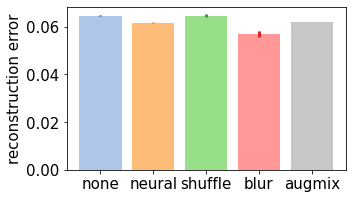

In [63]:
print(f'reconstructing from layer {l_idx}, processing nosie {noise}')
_, ax = plt.subplots(figsize=(5, 3))

for k_idx, key in enumerate(catalog_keys):
    if mses[key]:
        ecolor = tab20_colors[k_idx*2]
        fcolor = tab20_colors[k_idx*2+1]
        ax.bar(k_idx, np.mean(mses[key]), 0.8, yerr=np.std(mses[key])/len(mses[key])**0.5, facecolor=fcolor, ecolor=ecolor)
ax.set_xticks(np.arange(len(catalog_keys)))
ax.set_xticklabels(catalog_keys)
ax.set_ylabel('reconstruction error')
plt.show()

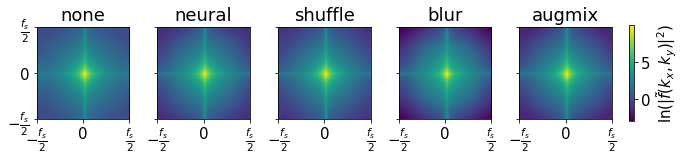

In [64]:
_, axes = plt.subplots(1, len(catalog), figsize=(2.5*len(catalog), 2.5), gridspec_kw={'wspace': 0.3})
vmin = np.min([np.log(np.array(v).min()) for v in f_reco.values()])
vmax = np.max([np.log(np.array(v).max()) for v in f_reco.values()])
for key, ax in zip(catalog_keys, axes):
    h = ax.imshow(np.log(np.mean(f_reco[key], axis=0)), extent=[-1, 1, -1, 1], vmin=vmin, vmax=vmax)
    ax.set_xticks([-1, 0, 1])
    ax.set_xticklabels([r'$-\frac{f_s}{2}$', '0', r'$\frac{f_s}{2}$'])
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels([])
    ax.set_title(key)
axes[0].set_yticklabels([r'$-\frac{f_s}{2}$', '0', r'$\frac{f_s}{2}$'])
plt.colorbar(h, ax=axes, shrink=0.7, pad=0.025, label=r'$\ln(|\tilde{f}(k_x, k_y)|^2)$')
plt.show()

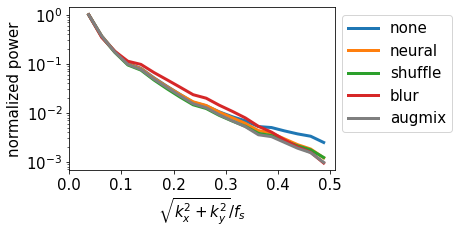

In [65]:
_, axes = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw={'width_ratios': [3, 1]})
hs = []
for k_idx, key in enumerate(catalog_keys):
    k_edges, f_means = radial_mean(np.mean(f_reco[key], axis=0), bin_num=20, exclude_cardinal=True)
    h, = axes[0].plot(k_edges, f_means/np.nanmax(f_means), color=tab20_colors[k_idx*2])
    # h, = axes[0].plot(k_edges, f_means, color=tab20_colors[k_idx*2])
    hs.append(h)
axes[0].set_xlabel(r'$\sqrt{k_x^2+k_y^2}/f_s$')
axes[0].set_ylabel('normalized power')
axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
axes[0].set_yscale('log')
axes[1].legend(hs, catalog_keys)
axes[1].axis('off')
plt.show()